In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [2]:
# Load dataset
df = pd.read_excel(r'gold_futures.xlsx')
df

FileNotFoundError: [Errno 2] No such file or directory: 'gold_futures.xlsx'

In [3]:
#make date column numeric instead of datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%Y%m%d').astype(int)
df

Date         Open         High          Low        Close  \
0     20200102  1518.099976  1528.699951  1518.000000  1524.500000   
1     20200103  1530.099976  1552.699951  1530.099976  1549.199951   
2     20200106  1580.000000  1580.000000  1560.400024  1566.199951   
3     20200107  1558.300049  1576.300049  1558.300049  1571.800049   
4     20200108  1579.699951  1604.199951  1552.300049  1557.400024   
...        ...          ...          ...          ...          ...   
1240  20241210  2662.300049  2698.199951  2661.000000  2697.600098   
1241  20241211  2701.800049  2733.800049  2693.100098  2733.800049   
1242  20241212  2725.100098  2725.100098  2677.399902  2687.500000   
1243  20241213  2688.199951  2689.300049  2647.899902  2656.000000   
1244  20241216  2658.300049  2663.300049  2651.000000  2651.399902   

        Adj Close  Volume Price Movement  
0     1524.500000     214             Up  
1     1549.199951     107             Up  
2     1566.199951     416             Up  
3     1571.800049      47             Up  
4     1557.400024     236           Down  
...           ...     ...            ...  
1240  2697.600098     437             Up  
1241  2733.800049    3387             Up  
1242  2687.500000    2365           Down  
1243  2656.000000    1125           Down  
1244  2651.399902    1125           Down  

[1245 rows x 8 columns]

In [4]:
# Prepare features and target
X = df.drop('Price Movement', axis=1)
y = df['Price Movement'].map({'Up': 1, 'Down': 0})

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Initialize models
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}

In [6]:
# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))

RandomForest Accuracy: 0.6948
              precision    recall  f1-score   support

           0       0.72      0.57      0.64       117
           1       0.68      0.80      0.74       132

    accuracy                           0.69       249
   macro avg       0.70      0.69      0.69       249
weighted avg       0.70      0.69      0.69       249

LogisticRegression Accuracy: 0.8394
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       117
           1       0.84      0.86      0.85       132

    accuracy                           0.84       249
   macro avg       0.84      0.84      0.84       249
weighted avg       0.84      0.84      0.84       249



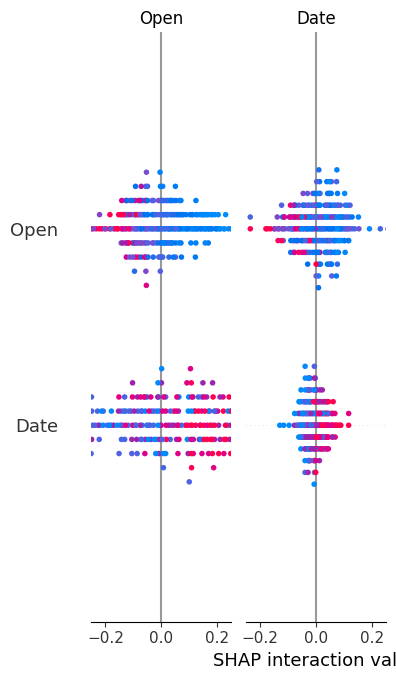

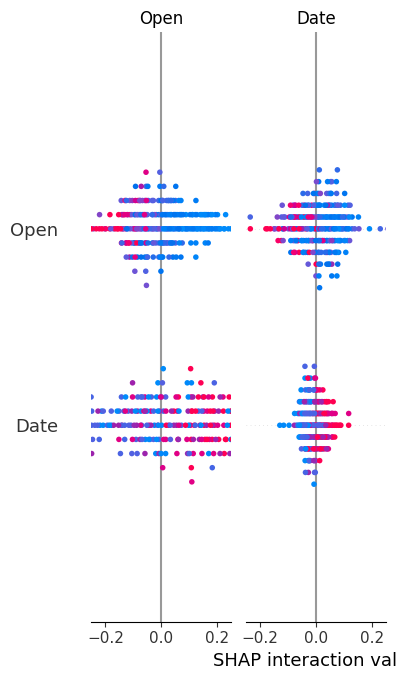

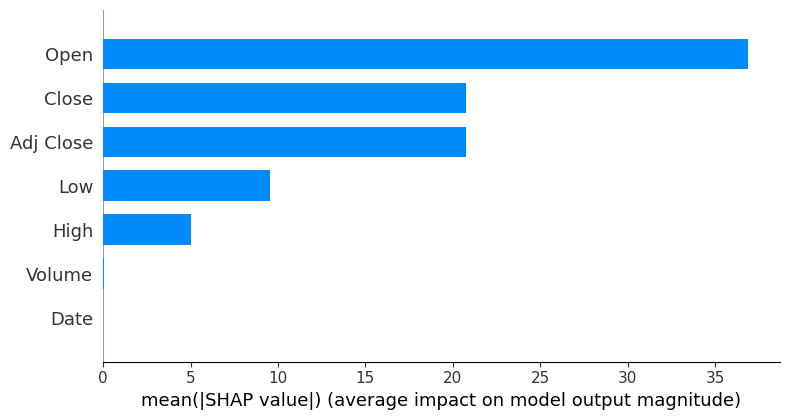

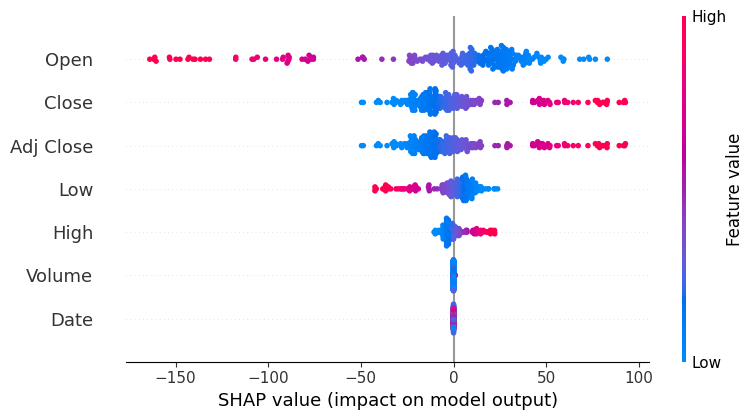

In [7]:
# SHAP Explanation for RandomForest
rf = models['RandomForest']
explainer_shap_rf = shap.TreeExplainer(rf)
shap_values = explainer_shap_rf.shap_values(X_test)  # Get shap values for all classes
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

#shap explanation for Logistic Regression
lr = models['LogisticRegression']
explainer_shap_lr = shap.Explainer(lr, X_train)
shap_values = explainer_shap_lr(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


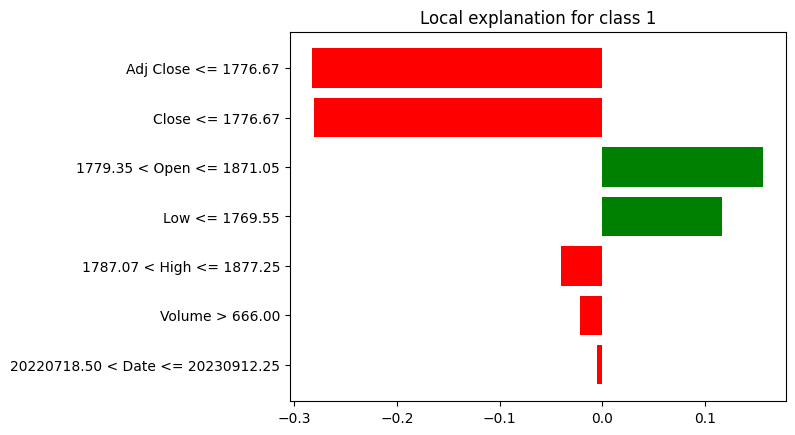

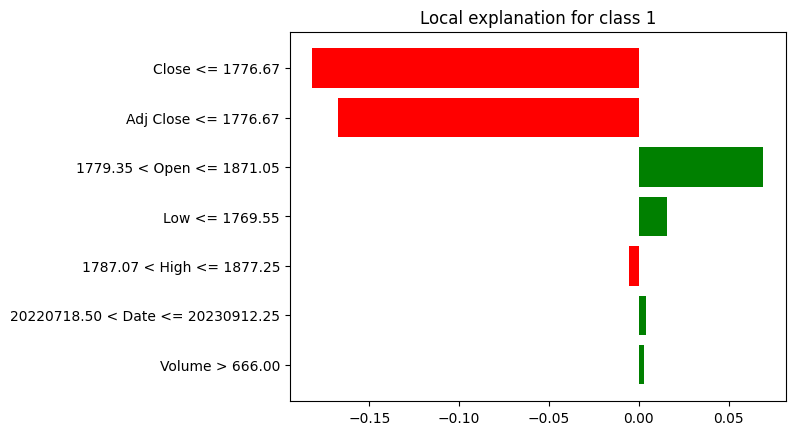

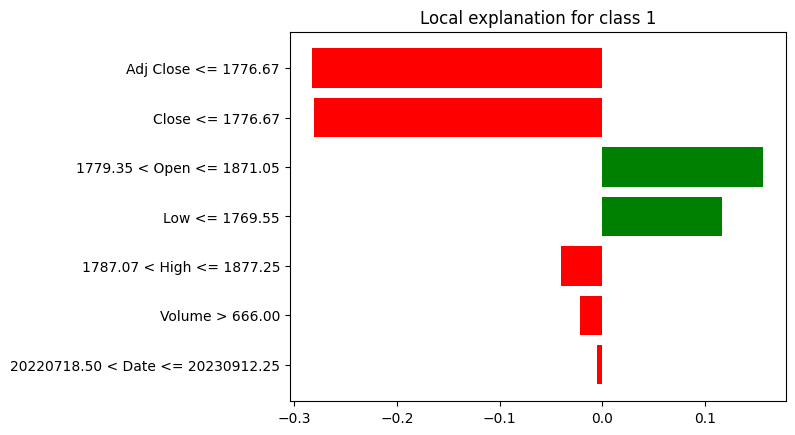

In [8]:
# LIME Explanation for RandomForest
explainer_lime_rf = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode='classification', feature_names=X_train.columns)
rf = models['RandomForest']
exp = explainer_lime_rf.explain_instance(X_test.values[0], rf.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)
exp.as_pyplot_figure()

# LIME Explanation for Logistic Regression
explainer_lime_lr = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode='classification', feature_names=X_train.columns)
lr = models['LogisticRegression']
exp = explainer_lime_lr.explain_instance(X_test.values[0], lr.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)
exp.as_pyplot_figure()

In [9]:
# Explain a single prediction
i = 0
exp = explainer_lime_rf.explain_instance(X_test.iloc[i], rf.predict_proba)
exp.show_in_notebook()


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

In [10]:
# Explain a single prediction
i = 0
exp = explainer_lime_lr.explain_instance(X_test.iloc[i], rf.predict_proba)
exp.show_in_notebook()

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

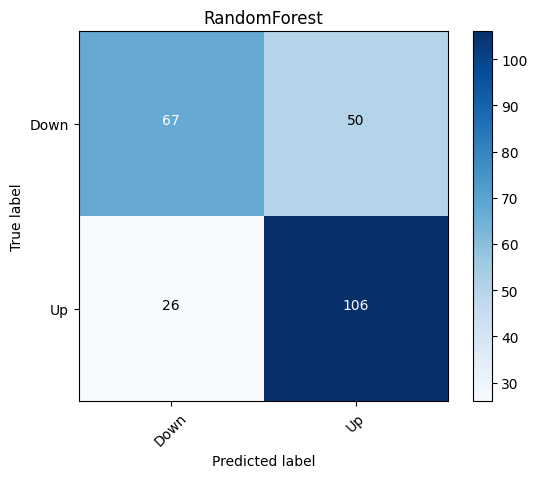

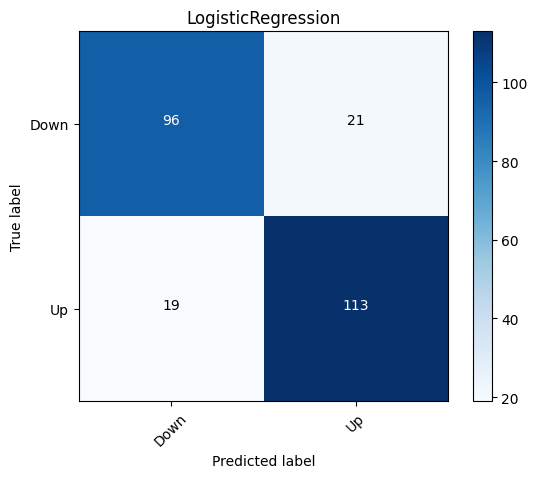

In [11]:
# Analyze Model Bias
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(y_test, models['RandomForest'].predict(X_test), ['Down', 'Up'], title='RandomForest')
plot_confusion_matrix(y_test, models['LogisticRegression'].predict(X_test), ['Down', 'Up'], title='LogisticRegression')


In [12]:
# Function to compute the metrics
def compute_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)  # Accuracy
    return tpr, fpr, fnr, accuracy

# Subset data based on price range (High vs. Low)
df_high = df[df['High'] > df['High'].median()]
df_low = df[df['Low'] < df['Low'].median()]

X_high = df_high.drop('Price Movement', axis=1)
y_high = df_high['Price Movement'].map({'Up': 1, 'Down': 0})

X_low = df_low.drop('Price Movement', axis=1)
y_low = df_low['Price Movement'].map({'Up': 1, 'Down': 0})

# Train models and compute metrics for both subsets
for name, model in models.items():
    model.fit(X_train, y_train)
    
    # Predictions on High and Low price ranges
    preds_high = model.predict(X_high)
    preds_low = model.predict(X_low)
    
    # Compute metrics for High Price subset
    tpr_high, fpr_high, fnr_high, accuracy_high = compute_metrics(y_high, preds_high)
    
    # Compute metrics for Low Price subset
    tpr_low, fpr_low, fnr_low, accuracy_low = compute_metrics(y_low, preds_low)
    
    # Print results
    print(f"\n{name} Metrics on High Price subset:")
    print(f"  TPR: {tpr_high:.4f}, FPR: {fpr_high:.4f}, FNR: {fnr_high:.4f}, Accuracy: {accuracy_high:.4f}")
    
    print(f"\n{name} Metrics on Low Price subset:")
    print(f"  TPR: {tpr_low:.4f}, FPR: {fpr_low:.4f}, FNR: {fnr_low:.4f}, Accuracy: {accuracy_low:.4f}")

    # Compute Disparate Impact Ratio (DIR) and Demographic Parity (DP)
    prop_pos_high = sum(preds_high) / len(preds_high)  # Proportion of positive predictions in high subset
    prop_pos_low = sum(preds_low) / len(preds_low)  # Proportion of positive predictions in low subset
    dir = prop_pos_high / prop_pos_low if prop_pos_low != 0 else float('inf')
    dp = abs(prop_pos_high - prop_pos_low)
    
    print(f"  Disparate Impact Ratio (DIR): {dir:.4f}")
    print(f"  Demographic Parity (DP): {dp:.4f}")



RandomForest Metrics on High Price subset:
  TPR: 0.9687, FPR: 0.1033, FNR: 0.0313, Accuracy: 0.9373

RandomForest Metrics on Low Price subset:
  TPR: 0.9540, FPR: 0.0743, FNR: 0.0460, Accuracy: 0.9405
  Disparate Impact Ratio (DIR): 1.1051
  Demographic Parity (DP): 0.0563

LogisticRegression Metrics on High Price subset:
  TPR: 0.8632, FPR: 0.2103, FNR: 0.1368, Accuracy: 0.8312

LogisticRegression Metrics on Low Price subset:
  TPR: 0.8252, FPR: 0.1689, FNR: 0.1748, Accuracy: 0.8280
  Disparate Impact Ratio (DIR): 1.1285
  Demographic Parity (DP): 0.0659


In [13]:
# Initialize SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train the RandomForest model on resampled data
rf_resampled = RandomForestClassifier(random_state=42)
rf_resampled.fit(X_train_resampled, y_train_resampled)

#Train the Logistic Regression model on resampled data
lr_resampled = LogisticRegression(max_iter=1000, random_state=42)
lr_resampled.fit(X_train_resampled, y_train_resampled)

# Evaluate the resampled rf model
preds_resampled = rf_resampled.predict(X_test)
acc_resampled = accuracy_score(y_test, preds_resampled)
print(f"RandomForest (Resampled) Accuracy: {acc_resampled:.4f}")
print(classification_report(y_test, preds_resampled))

# Evaluate the resampled lr model
preds_resampled = lr_resampled.predict(X_test)
acc_resampled = accuracy_score(y_test, preds_resampled)
print(f"Logistic Regression (Resampled) Accuracy: {acc_resampled:.4f}")
print(classification_report(y_test, preds_resampled))

RandomForest (Resampled) Accuracy: 0.7309
              precision    recall  f1-score   support

           0       0.73      0.68      0.70       117
           1       0.73      0.78      0.75       132

    accuracy                           0.73       249
   macro avg       0.73      0.73      0.73       249
weighted avg       0.73      0.73      0.73       249

Logistic Regression (Resampled) Accuracy: 0.8594
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       117
           1       0.88      0.85      0.86       132

    accuracy                           0.86       249
   macro avg       0.86      0.86      0.86       249
weighted avg       0.86      0.86      0.86       249



In [14]:
print("Original dataset class distribution:")
print(y_train.value_counts())

print("\nResampled dataset class distribution:")
print(pd.Series(y_train_resampled).value_counts())

Original dataset class distribution:
Price Movement
1    551
0    445
Name: count, dtype: int64

Resampled dataset class distribution:
Price Movement
0    551
1    551
Name: count, dtype: int64


In [15]:
# Define parameter grid for RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search with Cross-Validation
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Best hyperparameters
print(f"Best parameters: {grid_search_rf.best_params_}")

# Evaluate the model with the best hyperparameters
best_rf_model = grid_search_rf.best_estimator_
preds_best_rf = best_rf_model.predict(X_test)
acc_best_rf = accuracy_score(y_test, preds_best_rf)
print(f"RandomForest (Best Hyperparameters) Accuracy: {acc_best_rf:.4f}")
print(classification_report(y_test, preds_best_rf))

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
RandomForest (Best Hyperparameters) Accuracy: 0.7349
              precision    recall  f1-score   support

           0       0.74      0.67      0.70       117
           1       0.73      0.80      0.76       132

    accuracy                           0.73       249
   macro avg       0.74      0.73      0.73       249
weighted avg       0.74      0.73      0.73       249



In [16]:
# Define parameter grid for logistic regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Perform Grid Search with Cross-Validation
grid_search_lr = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42), param_grid=param_grid, cv=5)
grid_search_lr.fit(X_train_resampled, y_train_resampled)

# Best hyperparameters
print(f"Best parameters: {grid_search_lr.best_params_}")

# Evaluate the model with the best hyperparameters
best_lr_model = grid_search_lr.best_estimator_
preds_best_lr = best_lr_model.predict(X_test)
acc_best_lr = accuracy_score(y_test, preds_best_lr)
print(f"LogisticRegression (Best Hyperparameters) Accuracy: {acc_best_lr:.4f}")
print(classification_report(y_test, preds_best_lr))

Best parameters: {'C': 100, 'penalty': 'l2'}
LogisticRegression (Best Hyperparameters) Accuracy: 0.8594
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       117
           1       0.88      0.85      0.86       132

    accuracy                           0.86       249
   macro avg       0.86      0.86      0.86       249
weighted avg       0.86      0.86      0.86       249



c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\USER\AppData\Lo

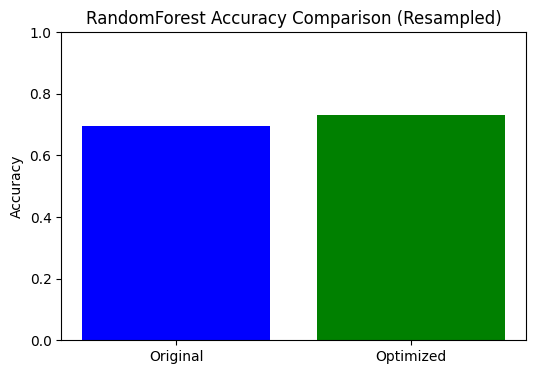

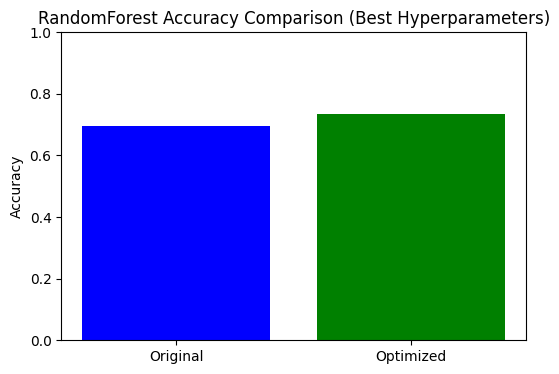

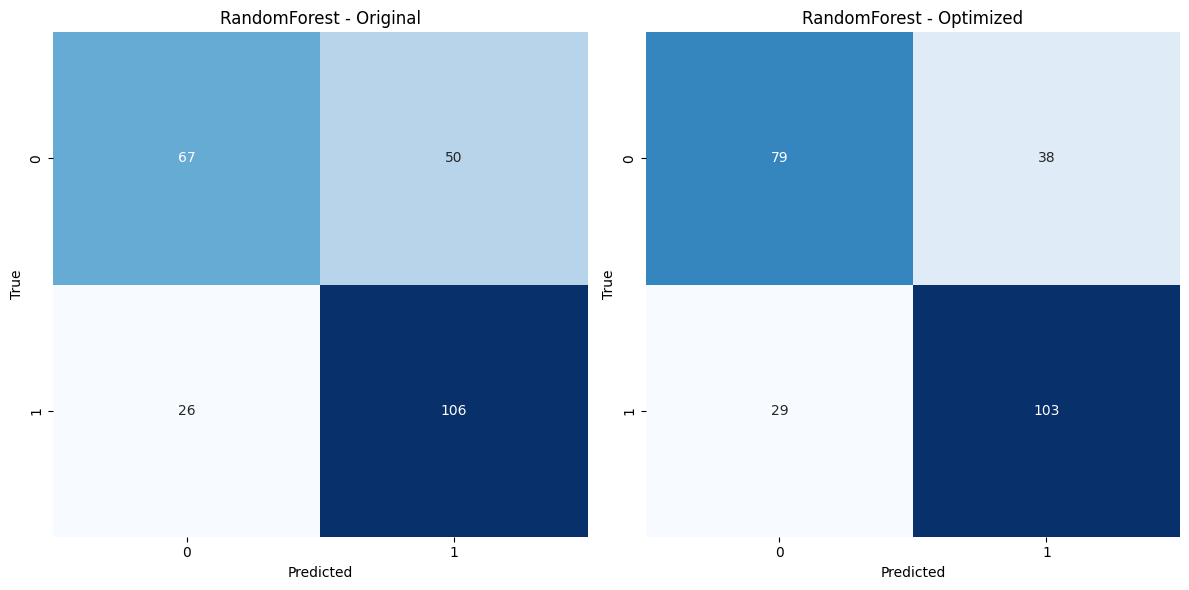

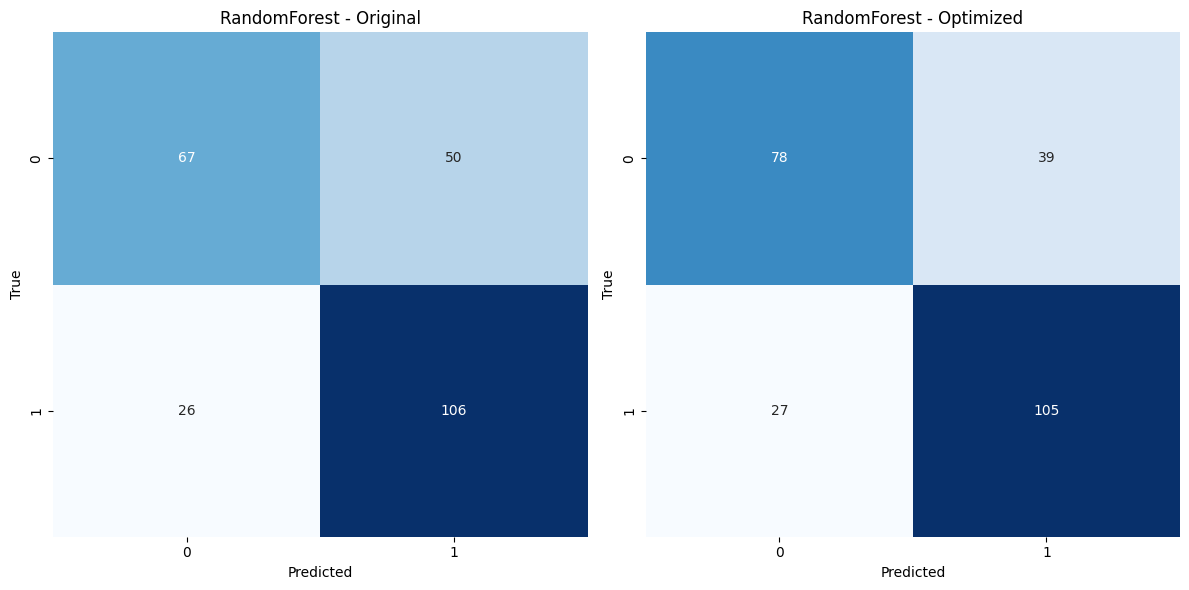

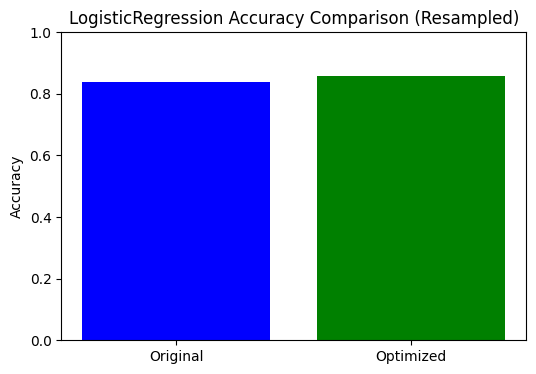

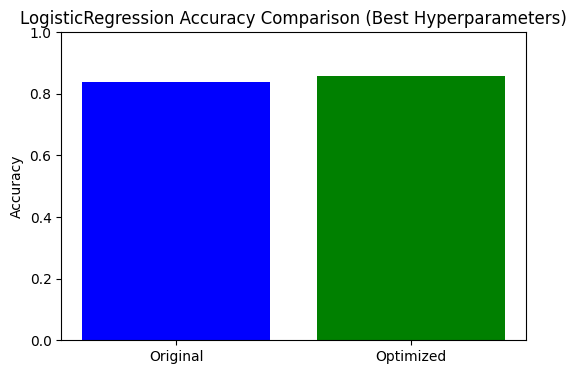

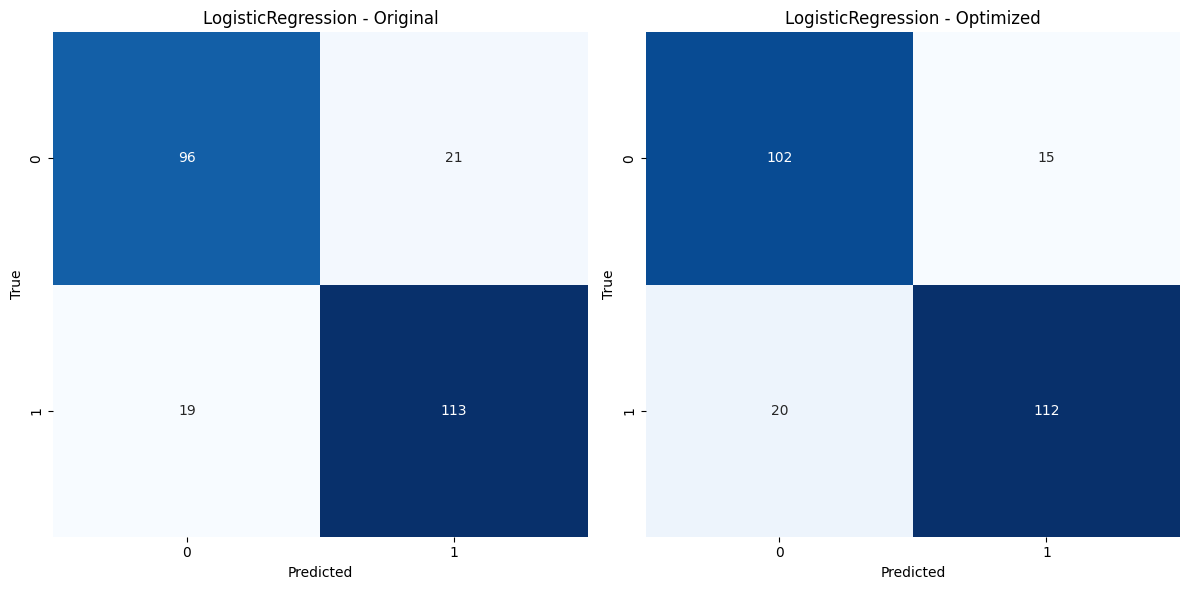

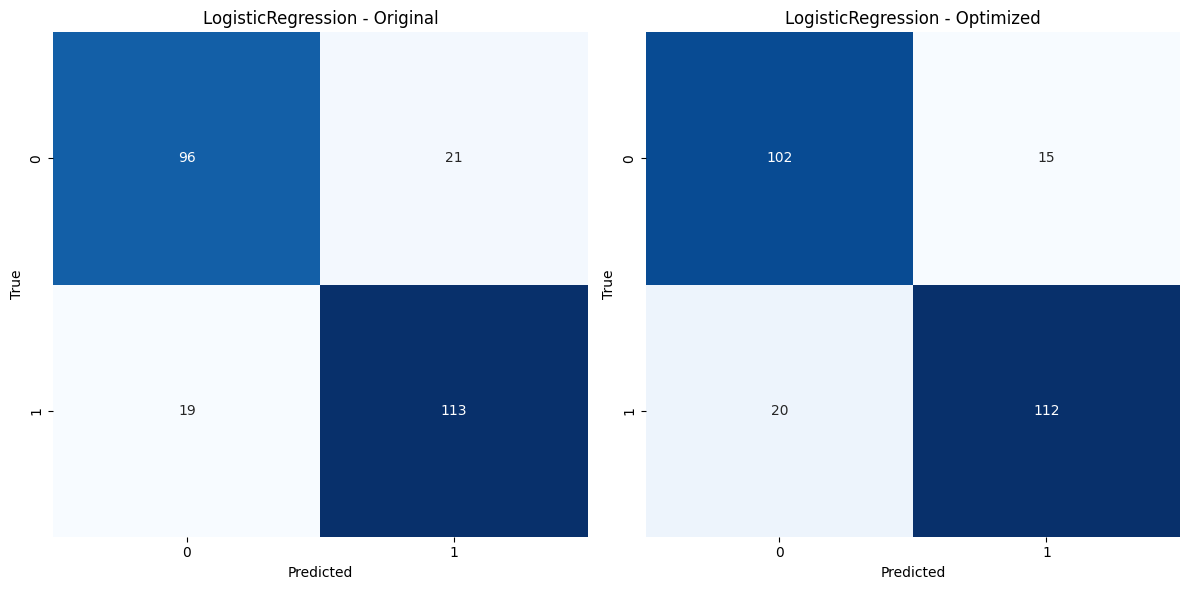

Classification Report for RandomForest (Resampled) (Original):
              precision    recall  f1-score   support

           0       0.72      0.57      0.64       117
           1       0.68      0.80      0.74       132

    accuracy                           0.69       249
   macro avg       0.70      0.69      0.69       249
weighted avg       0.70      0.69      0.69       249

Classification Report for RandomForest (Resampled) (Optimized):
              precision    recall  f1-score   support

           0       0.73      0.68      0.70       117
           1       0.73      0.78      0.75       132

    accuracy                           0.73       249
   macro avg       0.73      0.73      0.73       249
weighted avg       0.73      0.73      0.73       249

Classification Report for RandomForest (Best Hyperparameters) (Original):
              precision    recall  f1-score   support

           0       0.72      0.57      0.64       117
           1       0.68      0.80   

In [17]:
# Create a function to plot accuracy before and after optimization
def plot_comparison(model_name, original_acc, optimized_acc, model_type):
    # Accuracy Comparison Plot
    labels = ['Original', 'Optimized']
    accuracy_values = [original_acc, optimized_acc]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, accuracy_values, color=['blue', 'green'])
    plt.title(f'{model_name} Accuracy Comparison ({model_type})')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

# Create a function to plot confusion matrix
def plot_confusion_matrix_comparison(y_true, y_pred_original, y_pred_optimized, model_name):
    cm_original = confusion_matrix(y_true, y_pred_original)
    cm_optimized = confusion_matrix(y_true, y_pred_optimized)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
    axes[0].set_title(f'{model_name} - Original')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False)
    axes[1].set_title(f'{model_name} - Optimized')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')

    plt.tight_layout()
    plt.show()

# Create a function to print classification report
def print_classification_reports(y_true, y_pred_original, y_pred_optimized, model_name):
    print(f"Classification Report for {model_name} (Original):")
    print(classification_report(y_true, y_pred_original))

    print(f"Classification Report for {model_name} (Optimized):")
    print(classification_report(y_true, y_pred_optimized))

# RandomForest Example
# Assuming we have the following variables for RandomForest
rf_preds = rf.predict(X_test)  # Original RF predictions
rf_resampled_preds = rf_resampled.predict(X_test)  # Resampled RF predictions
rf_best_preds = best_rf_model.predict(X_test)  # Best hyperparameters RF predictions

# Compare accuracy (Original vs Optimized - resampled, grid search)
plot_comparison('RandomForest', accuracy_score(y_test, rf_preds), accuracy_score(y_test, rf_resampled_preds), 'Resampled')
plot_comparison('RandomForest', accuracy_score(y_test, rf_preds), accuracy_score(y_test, rf_best_preds), 'Best Hyperparameters')

# Confusion Matrix Comparison
plot_confusion_matrix_comparison(y_test, rf_preds, rf_resampled_preds, 'RandomForest')
plot_confusion_matrix_comparison(y_test, rf_preds, rf_best_preds, 'RandomForest')

# Logistic Regression Example
# Assuming we have the following variables for Logistic Regression
log_reg_preds = lr.predict(X_test)  # Original Logistic Regression predictions
log_reg_resampled_preds = lr_resampled.predict(X_test)  # Resampled Logistic Regression predictions
log_reg_best_preds = best_lr_model.predict(X_test)  # Best hyperparameters Logistic Regression predictions

# Compare accuracy (Original vs Optimized - grid search)
plot_comparison('LogisticRegression', accuracy_score(y_test, log_reg_preds), accuracy_score(y_test, log_reg_resampled_preds), 'Resampled')
plot_comparison('LogisticRegression', accuracy_score(y_test, log_reg_preds), accuracy_score(y_test, log_reg_best_preds), 'Best Hyperparameters')

# Confusion Matrix Comparison
plot_confusion_matrix_comparison(y_test, log_reg_preds, log_reg_resampled_preds, 'LogisticRegression')
plot_confusion_matrix_comparison(y_test, log_reg_preds, log_reg_best_preds, 'LogisticRegression')

# Print Classification Reports
print_classification_reports(y_test, rf_preds, rf_resampled_preds, 'RandomForest (Resampled)')
print_classification_reports(y_test, rf_preds, rf_best_preds, 'RandomForest (Best Hyperparameters)')
print_classification_reports(y_test, log_reg_preds, log_reg_resampled_preds, 'LogisticRegression (Resampled)')
print_classification_reports(y_test, log_reg_preds, log_reg_best_preds, 'LogisticRegression (Best Hyperparameters)')